### Copyright-protected material, all rights reserved. (c) University of Vienna.
_Copyright Notice of the corresponding course at Moodle applies. <br> Only to be used in the MRE course._

# MRE Assignment 1 - Digital Image Processing

In this assignment you will use Python (using Pillow or OpenCV) to load, transcode and store images. You will also use the libraries to extract some basic metadata from the images and store them in a data structure for easy access.

In this notebook, you will implement your solution. This notebook will be imported into the "*_def.ipynb" notebook.

Of course you can include code for testing your implementation in this implementation notebook, but code for testing and output generated for testing is not going to be assessed.

Of course, your code for the solutions in this notebook will be inspected and is subject to grading.


## Setup

For general installation instructions, please refer to the ressources given for all the assignments [in Moodle](https://moodle.univie.ac.at/course/view.php?id=260637#section-13).

If the cell below executes without error, you can start the assignment!

In [119]:
# -------- Imports --------
# Please do not change the contents of this cell!

# In case you work in a local environment on your own machine,
# how to install the required packages:
#   PIP:     pip install <name> / pip install --upgrade <name>
#   CONDA:   conda install -c conda-forge <name>  /  conda install -c anaconda <name>


# Imports required by us.
import cv2                             # opencv-python
from PIL import Image                  # pillow
from PIL.ExifTags import TAGS
from matplotlib import pyplot as plt   # matplotlib
from sklearn.metrics.pairwise import cosine_similarity  # scikit-learn
import numpy as np                     # numpy
import pandas as pd                    # pandas
from IPython.display import display    # packaged with python

# This directive will allow matplotlib to render interactive plots in the notebook.
%matplotlib widget

In the cells below, place your own imports, global variables, (helper) functions and classes. Feel free to add cells here as you see fit.

In [120]:
# Please place your own imports here.
from PIL import ImageFilter 
import glob

In [122]:
# Place any helper functions, global variables and classes here.

## Task 1.1: Image formats transformation and adding filters


In [148]:
# Write your function here.

# Transcodes images to JPEG format of adjustable quality (for JPEG).
def JPEGImageConverter(inputImg: str, outputDir: str, quality: float = 1.0) -> None:
    quality_factor = int(quality*100)
    img = Image.open(inputImg)#.convert('RGB')
    img.convert('RGB').save(outputDir,'JPEG', quality = quality_factor)

In [75]:
# Test your function here.
JPEGImageConverter("images/Task1.1/the_real_firefox_dithered.bmp", "images/Task1.1/converted" + ".jpeg")

In [149]:
# Add Blur filter
def BlurImage(inputImg: str) -> None:
    img = Image.open(inputImg)
    img.convert('RGB').filter(ImageFilter.BLUR).save("images/Task1.1/blurredimg.jpg")

In [73]:
# Test your function here.
BlurImage("images/Task1.1/b1murene.gif")

## Task 1.2:  Extract / Get Image Metadata

In [198]:
# Write your function here. 

# Extracts metadata from an image and places them into a Pandas DataFrame.
def ImageMetadataGenerator(inputImage: str) -> pd.DataFrame:
    images = glob.glob(inputImage)
    df = pd.DataFrame()
    rows = []
    for image in images:
        with open(image, 'rb') as file:
            img = Image.open(file)

            metadata = img.getexif()
    
            rows = np.append(rows, file.name)
            
            # alpha channel
            if (img.mode == 'RGBA'):
                _, _, _, alpha = img.split()
            else :
                alpha = 'None'
        
            # width, height
            width, height = img.size
            
            # no of channels
            # https://stackoverflow.com/questions/52962969/number-of-channels-in-pil-pillow-image
            channels = len(img.getbands())
            
            # colorspace type
            colorspace_name = img.mode
            
            # to get colorspace as int?
            #colorspace = metadata.get(40961)
            
            # bits per pixel
            # https://stackoverflow.com/questions/1996577/how-can-i-get-the-depth-of-a-jpg-file answer#1
            mode_types_bits = {'P': 8, 'RGB': 24, 'YCbCr': 24, 'RGBA': 32, 'CMYK': 32}
            bpp = mode_types_bits[colorspace_name]
                        
            # no of components
            components = channels

            # manufacturer
            manufacturer = metadata.get(271)
            
            # software
            software = metadata.get(305)

            data = np.array(([width, height, components, channels, bpp, colorspace_name, alpha, manufacturer, software]))
            df2 = pd.DataFrame(data = [data],columns = ['width', 'height', 'no of components', 'no of channels', 'bits per pixel', 'colorspace type', 'alpha channel', 'manufacturer', 'software'])
        
            df = df.append(df2 ,ignore_index = True)    
    
    df.index = rows
    return df


In [199]:
# Test your function here.
ImageMetadataGenerator("images/Task1.2/*")

,width,height,no of components,no of channels,bits per pixel,colorspace type,alpha channel,manufacturer,software
images/Task1.2/b17barb026_dithered.gif,1024,768,1,1,8,P,None,None,None
images/Task1.2/b17maartent1427.gif,50,38,1,1,8,P,None,None,None
images/Task1.2/b2seaanimals005.jpg,1600,1200,3,3,24,RGB,None,NIKON,Adobe Photoshop 7.0
images/Task1.2/b3_seaanimals014.jpg,1600,1200,3,3,24,RGB,None,NIKON,E995v1.6
images/Task1.2/b1murene.jpg,1862,1241,3,3,24,RGB,None,None,None
images/Task1.2/b9nature_plants064.jpg,2560,1920,3,3,24,RGB,None,None,None
images/Task1.2/b1shell008.jpg,1341,1023,3,3,24,RGB,None,None,None
images/Task1.2/b17barb026.jpg,1024,768,3,3,24,RGB,None,Canon,Adobe Photoshop CS3 Windows
images/Task1.2/b1murene.gif,500,333,1,1,8,P,None,None,None


## Task 1.3: Drawing circles around objects in an image

In [189]:
# Write your function here. 

# Identifies shapes in an images and draws circles around them.
def IdentifyObjects(inputImage: str) -> None:
    img = cv2.imread(inputImage)
    
    new_img = cv2.imread(inputImage)
    
    grayscale = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
 
    #reduces noise 
    blur = cv2.GaussianBlur(grayscale, (5, 5), 0)
    
    returnValue, threshImg = cv2.threshold(blur, 240, 255, cv2.THRESH_BINARY_INV)
    
    contours, hierarchies = cv2.findContours(threshImg, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    cv2.fillPoly(new_img, pts = contours, color = (0,0,0))

    # https://www.pyimagesearch.com/2016/02/01/opencv-center-of-contour/
    for ctr in contours:
        
        M = cv2.moments(ctr)
        
        # binary img: counting all non zero pixels, greyscale img: sum of pixel intensity values
        
        area = M['m00']
        
        # centroid = mean position of all points
        
        #M10 = sum of all non zero pixels x coord
        
        cX = int(M['m10'] / area)
        
        #M01 = sum of all non zero pixels y coord
        
        cY = int(M['m01'] / area)
        
        cv2.circle(img, (cX, cY), 100, (0, 0, 255), 2)

            
    cv2.imwrite("images/Task1.3/modified.jpg", img)

In [188]:
# Test your function here.
IdentifyObjects('images/Task1.3/partyballoons-2.jpg')

## Task 1.4: Duplicate image finder using cosine similarity

In [168]:
# Calculates a histogram for one image.
def ImageHistogramGenerator(inputImage: str) -> np.array:
    
    # this verifies if correct using calcHist function
    #img = Image.open(inputImage)
    #grayscale = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    #histr = cv2.calcHist([grayscale],[0],None,[256],[0,256])
    #x_axis = np.arange(0, 256)
    #print(histr.flatten())
    #plt.bar(x_axis, histr.flatten())
    #plt.show()
    
    img = Image.open(inputImage)
   
    grayscale = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
    
    width, height = img.size
   
    y_axis = np.zeros((1, 256))
    x_axis = np.arange(0, 256)

    for i in range(0, height):
        for j in range(0, width):
            y_axis[0][grayscale[i,j]] += 1
    
    no_pixels = width*height
    
    intensities = y_axis.flatten()
    
    # transforming into percent
    for i in range(0, len(intensities)):
        intensities[i] /= no_pixels 
        intensities[i] *= 100
    
    #plt.figure()
    #plt.bar(x_axis, intensities)
    #plt.show()

    return y_axis

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
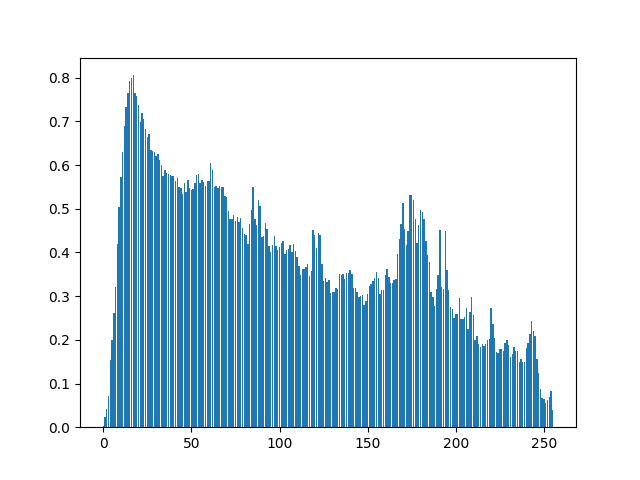

array([[  20.,  142.,  252.,  446.,  947., 1242., 1624., 1982., 2601.,
        3124., 3551., 3894., 4272., 4543., 4738., 4903., 4947., 4987.,
        4737., 4696., 4563., 4321., 4446., 4373., 4228., 4106., 4153.,
        3926., 3919., 3899., 3845., 3869., 3792., 3717., 3565., 3639.,
        3600., 3582., 3566., 3560., 3553., 3485., 3524., 3399., 3393.,
        3306., 3457., 3328., 3501., 3390., 3354., 3368., 3454., 3570.,
        3589., 3464., 3502., 3471., 3421., 3484., 3488., 3746., 3647.,
        3408., 3411., 3392., 3418., 3396., 3410., 3273., 3263., 3069.,
        2954., 2954., 3007., 2926., 2973., 2907., 2967., 2822., 2738.,
        2730., 2594., 2874., 3084., 3403., 2946., 2864., 3222., 3138.,
        2688., 2707., 2900., 2803., 2567., 2481., 2582., 2709., 2564.,
        2508., 2547., 2606., 2642., 2456., 2509., 2527., 2576., 2482.,
        2595., 2497., 2408., 2281., 2157., 2247., 2247., 2265., 2313.,
        2137., 2216., 2790., 2723., 2545., 2754., 2728., 2317., 2074.,
      

In [161]:
# Test your function here.
ImageHistogramGenerator('images/jawa-3.jpg')

In [155]:
# Find duplicate images and return their similarity scores in a dataframe.
def FindDuplicateImages(inputDir1 : str, inputDir2: str, similarityThreshold: float = 1.0) -> pd.DataFrame:
    imgs1 = glob.glob(inputDir1)
    imgs2 = glob.glob(inputDir2)

    df = pd.DataFrame(columns = ["inputDir1", "inputDir2","similarityThreshold"])

    for img1 in imgs1:
        with open(img1, 'rb') as file1:
            image1 = Image.open(file1)
            hist1 = ImageHistogramGenerator(img1) 
            hist1 = hist1.flatten()
        data = []
        for img2 in imgs2:
            with open(img2, 'rb') as file2:
                image2 = Image.open(file2)
                hist2 = ImageHistogramGenerator(img2)
                hist2 = hist2.flatten()
                
                cos = cosine_similarity([hist1], [hist2])
                names = np.array([img1, img2])
                similarity = cos.flatten()
                
                df2 = pd.DataFrame({"inputDir1": [img1], "inputDir2": [img2], "similarityThreshold": similarity})
                df = df.append(df2 ,ignore_index = True)      
 
    return df


In [156]:
# Test your function here.
FindDuplicateImages("images/unu/*", "images/doi/*", 1.0)

,inputDir1,inputDir2,similarityThreshold
0,images/unu/b2seaanimals005.jpg,images/doi/ml-1.jpg,0.219597
1,images/unu/b2seaanimals005.jpg,images/doi/b2seaanimals005.jpg,1.000000
2,images/unu/b2seaanimals005.jpg,images/doi/b1murene.jpg,0.213493
3,images/unu/b3_seaanimals014.jpg,images/doi/ml-1.jpg,0.284395
4,images/unu/b3_seaanimals014.jpg,images/doi/b2seaanimals005.jpg,0.316294
5,images/unu/b3_seaanimals014.jpg,images/doi/b1murene.jpg,0.338027
6,images/unu/ml_2.jpg,images/doi/ml-1.jpg,0.833135
7,images/unu/ml_2.jpg,images/doi/b2seaanimals005.jpg,0.312118
8,images/unu/ml_2.jpg,images/doi/b1murene.jpg,0.284664
9,images/unu/b1murene.jpg,images/doi/ml-1.jpg,0.175018
